# 12.11. Learning Rate Scheduling¶
Most obviously the magnitude of the learning rate matters. If it is too large, optimization diverges, if it is too small, it takes too long to train or we end up with a suboptimal result. We saw previously that the condition number of the problem matters (see e.g., Section 12.6 for details). Intuitively it is the ratio of the amount of change in the least sensitive direction vs. the most sensitive one.

Secondly, the rate of decay is just as important. If the learning rate remains large we may simply end up bouncing around the minimum and thus not reach optimality. Section 12.5 discussed this in some detail and we analyzed performance guarantees in Section 12.4. In short, we want the rate to decay, but probably more slowly than 
 
 which would be a good choice for convex problems.

Another aspect that is equally important is initialization. This pertains both to how the parameters are set initially (review Section 5.4 for details) and also how they evolve initially. This goes under the moniker of warmup, i.e., how rapidly we start moving towards the solution initially. Large steps in the beginning might not be beneficial, in particular since the initial set of parameters is random. The initial update directions might be quite meaningless, too.

Lastly, there are a number of optimization variants that perform cyclical learning rate adjustment. This is beyond the scope of the current chapter. We recommend the reader to review details in Izmailov et al. (2018), e.g., how to obtain better solutions by averaging over an entire path of parameters.

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l


def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# The code is almost identical to `d2l.train_ch6` defined in the
# lenet section of chapter convolutional neural networks
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # Using PyTorch In-Built scheduler
                scheduler.step()
            else:
                # Using custom defined scheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

/home/athapar/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)


train loss 0.174, train acc 0.933, test acc 0.893


In [3]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr

print(f'Using a learning rate of {lr} for the next training run')

Using a learning rate of 0.1 for the next training run


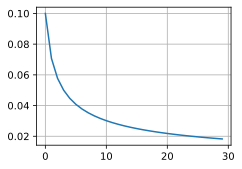

In [5]:
class SquareRootScheduler:
    def __init__(self, lr):
        self.lr = lr
        
    def __call__(self, num_update):
        return self.lr * pow(num_update + 1, -.5)

scheduler = SquareRootScheduler(lr)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])
d2l.plt.show()

In [ ]:
lr_scheduler = lr_scheduler.MuliS